In [1]:
import pandas as pd
import numpy as np
import json
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


c:\Users\Sandushke_140453\AppData\Local\anaconda3\envs\diaTest\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the Yelp review dataset in JSON format
data = []
with open('yelp_academic_dataset_review.json', 'r', encoding='utf-8') as file:
    for _ in range(10000):  # Load only 10,000 data points
        line = file.readline()
        if not line:
            break
        data.append(json.loads(line))

# Convert the JSON data to a DataFrame
yelp_data = pd.DataFrame(data)

In [3]:
yelp_data.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [4]:
# Select the necessary features
yelp_data = yelp_data[['text', 'stars']]

# Map star ratings to sentiment labels (e.g., 0 for 1-2 stars, 1 for 3 stars, 2 for 4-5 stars)
yelp_data['sentiment'] = yelp_data['stars'].apply(lambda x: 0 if x <= 2 else 1)

In [5]:
# Split data into train, validation, and test sets
train_data, test_data = train_test_split(yelp_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

In [6]:
# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Tokenize the text data
tokenized_data = tokenizer(yelp_data['text'].tolist(), truncation=True, padding=True, return_tensors='pt')

In [8]:
# Tokenize and preprocess the data
def tokenize_data(data):
    input_ids = []
    attention_masks = []
    labels = []

    for index, row in data.iterrows():
        review = row['text']
        label = row['sentiment']

        encoded_data = tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=128, 
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_data['input_ids'])
        attention_masks.append(encoded_data['attention_mask'])
        labels.append(label)

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

train_input_ids, train_attention_masks, train_labels = tokenize_data(train_data)
val_input_ids, val_attention_masks, val_labels = tokenize_data(val_data)
test_input_ids, test_attention_masks, test_labels = tokenize_data(test_data)

In [9]:
# Define dataloaders
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [10]:
# Check if a GPU is available; if not, use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Move the model to the appropriate device
model.to(device)

c:\Users\Sandushke_140453\AppData\Local\anaconda3\envs\diaTest\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [11]:
# Training loop
from tqdm import tqdm
import torch

num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_dataloader)
    print(f'Average Loss: {average_loss:.4f}')

Epoch 1: 100%|██████████| 250/250 [2:26:47<00:00, 35.23s/it]  

Average Loss: 0.2321


In [12]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in tqdm(val_dataloader, desc='Validation'):
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1).tolist()
    predictions.extend(predicted_labels)
    true_labels.extend(labels.tolist())


# Generate classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions)

print(f'Validation Accuracy: {accuracy:.4f}')
print(report)


Validation: 100%|██████████| 32/32 [04:33<00:00,  8.55s/it]

Validation Accuracy: 0.9550
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       182
           1       0.97      0.97      0.97       818

    accuracy                           0.95      1000
   macro avg       0.93      0.92      0.92      1000
weighted avg       0.95      0.95      0.95      1000



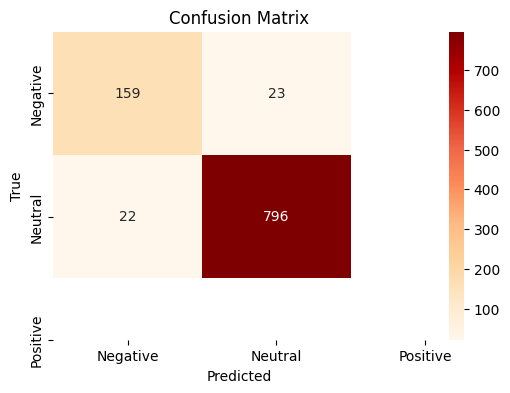

In [35]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='OrRd', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [28]:
def analyze_sentiment(comment):
    # Tokenize and preprocess the comment
    inputs = tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=128,  # You can adjust the maximum sequence length
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    # Perform inference
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    # Define sentiment labels
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    
    # Get the sentiment label and score
    sentiment_label = sentiment_labels[predicted_label]
    sentiment_score = torch.softmax(logits, dim=1)[0][predicted_label].item()

    return sentiment_label, sentiment_score


In [40]:
comment = "it is bad"
sentiment_label, sentiment_score = analyze_sentiment(comment)

print(f"Sentiment: {sentiment_label}")
print(f"Sentiment Score: {sentiment_score:.4f}")

Sentiment: Negative
Sentiment Score: 0.7405


In [41]:
# Print tokenized input
print("Tokenized Input:", tokenizer.tokenize(comment))

# Perform inference
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

# Print raw output scores (logits)
print("Raw Output Scores (Logits):", outputs.logits)


Tokenized Input: ['it', 'Ġis', 'Ġbad']
Raw Output Scores (Logits): tensor([[-3.5387,  3.2674],
        [-3.5281,  3.2798],
        [-3.4681,  3.1858],
        [-1.5621,  1.5637],
        [-3.6392,  3.3528],
        [-3.6243,  3.3142],
        [-2.3935,  2.2757],
        [-3.5677,  3.2877]])
